# Tic-Tac-Toe Endgame Classifier

This notebook demonstrates how to build a machine learning model to predict whether a player ('x') has won a game of Tic-Tac-Toe based on the board configuration.

## 1. Imports
First, we import all the necessary libraries.
* **Pandas & NumPy**: For data manipulation.
* **Seaborn & Matplotlib**: For visualizing data and results (like the confusion matrix).
* **Scikit-Learn (sklearn)**: For machine learning tasks like splitting data, training the model, and evaluating metrics.
* **JSON**: For saving the trained model and its parameters.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 2. Load and Inspect Data

Here we load the dataset.

**Important Improvement:** The original `tic-tac-toe.data` file does not have a header row (the first row is actual data, not column names). We use `header=None` to tell pandas this, and we manually provide the column names so we don't lose that first data point.

In [4]:
# Define column names manually since the file lacks a header
column_names = [
    'top-left-square', 'top-middle-square', 'top-right-square',
    'middle-left-square', 'middle-middle-square', 'middle-right-square',
    'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
    'class'
]

# Load the dataset
df = pd.read_csv('tic-tac-toe.data', names=column_names, header=None)

print(f"Dataset Shape: {df.shape}")
print("First 5 rows of the dataset:")
display(df.head())

Dataset Shape: (958, 10)
First 5 rows of the dataset:


,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


## 3. Exploratory Data Analysis (EDA)

Before training, it is helpful to understand the data distribution.
*   **Class Balance:** We check if the dataset is balanced between 'positive' (wins) and 'negative' (losses/ties).
*   **Feature Distribution:** We visualize how often 'x', 'o', and 'b' (blank) appear in different board positions.


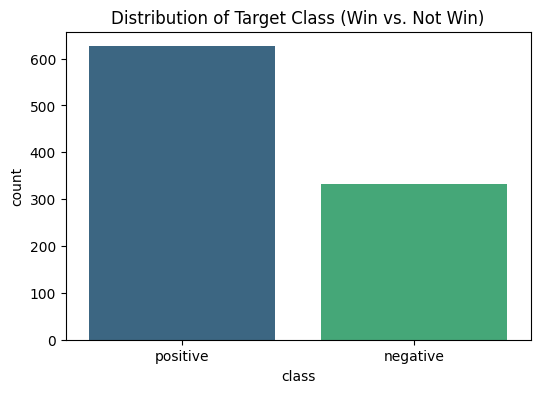

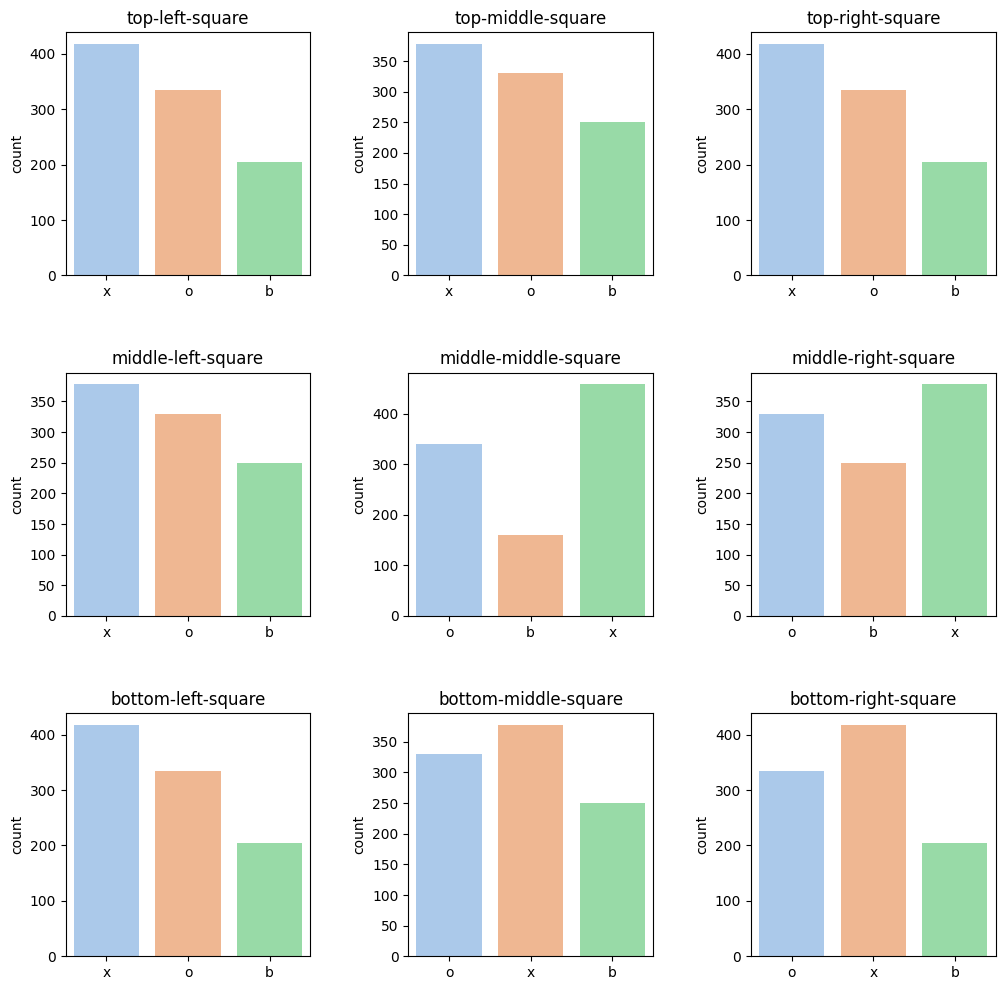

In [5]:
# 1. Check the Target Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df, hue='class', palette='viridis')
plt.title('Distribution of Target Class (Win vs. Not Win)')
plt.show()

# 2. Visualize Feature Distributions
# We'll plot the distribution of moves (x, o, b) for each board position
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

columns = df.columns[:-1] # Exclude the target column
for i, col in enumerate(columns):
    row = i // 3
    col_idx = i % 3
    sns.countplot(x=col, data=df, ax=axes[row, col_idx],hue=col, palette='pastel')
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].set_xlabel('')

plt.show()


**Key Observations:**
1.  **'x' Dominance:** In most squares (e.g., `top-left`, `top-right`, `bottom-left`), 'x' appears more frequently than 'o'. This is expected because 'x' typically makes the first move in Tic-Tac-Toe, leading to a slightly higher presence on the board in many game states.
2.  **Center Square Importance:** The `middle-middle-square` shows a distinct distribution where 'x' has a very high count compared to 'b'. This suggests the center is a highly contested strategic position that players prioritize filling early.
3.  **Blank Spaces ('b'):** The count of blank spaces is generally lower than 'x' or 'o' across most squares. This indicates that the dataset primarily consists of **end-game scenarios** or near-complete games where most board positions have already been played.
4.  **Symmetry:** The corner squares (`top-left`, `top-right`, `bottom-left`, `bottom-right`) exhibit very similar distributions, reflecting the symmetrical nature of the game board.

### 4. Data Preprocessing

Machine learning models typically require numerical input. Our board data currently uses characters:
* `x` (Player X)
* `o` (Player O)
* `b` (Blank)

We will convert these into numbers:
* `x` -> `1`
* `o` -> `-1`
* `b` -> `0`

We also convert the target class (`positive`/`negative`) into `1` and `0`.

In [6]:
def preprocess_data(df):
    """Prepares the dataframe for training."""

    # 1. Separate Features (Board state) and Target (Win/Loss)
    X = df.iloc[:, :9]  # First 9 columns
    y = df.iloc[:, 9]   # Last column (class)

    # 2. Define mapping for board values
    board_mapping = {'x': 1, 'o': -1, 'b': 0}

    # 3. Apply mapping to features
    # Using apply + map to handle the transformation safely across all columns
    X_encoded = X.apply(lambda col: col.map(board_mapping))

    # 4. Encode labels: positive (win) = 1, negative (loss) = 0
    y_encoded = (y == 'positive').astype(int)

    # 5. Split into Training and Test sets
    # stratify=y_encoded ensures both sets have a similar ratio of wins/losses
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)

Training set size: 766
Test set size: 192


## 5. Model Training

### **Logistic Regression**

For the first model, we will use **Logistic Regression**. Despite its name, it is a classification algorithm used to predict binary outcomes (1 or 0).

We will also save the model parameters (weights and bias) to a JSON file, which can be useful if you want to export the logic to another language (like C or JavaScript) later.

In [7]:
print("\nTraining Logistic Regression Model...")
# Initialize and train the model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
# Calculate Accuracy
train_acc = log_model.score(X_train, y_train)
test_acc = log_model.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
# Export parameters to JSON
params = {
    'model_type': 'logistic_regression',
    'weights': log_model.coef_.tolist()[0], # Flatten the list
    'bias': log_model.intercept_.tolist()[0],
    'n_features': X_train.shape[1]
}
with open('logistic_regression_params.json', 'w') as f:
    json.dump(params, f, indent=2)
print("Model parameters saved to 'logistic_regression_params.json'")


Training Logistic Regression Model...
Train Accuracy: 0.9856
Test Accuracy:  0.9740
Model parameters saved to 'logistic_regression_params.json'


### Naive Bayes Model

Next, we will implement a Naive Bayes classifier. This probabilistic model is often used as a baseline for classification tasks.
*   We use `GaussianNB` here, which assumes features follow a normal distribution. While our data is categorical, GaussianNB often performs surprisingly well on one-hot encoded or integer-encoded data.
*   We fit the model on the same training data and evaluate it on the test set.


In [8]:
print("\nTraining Gaussian Naive Bayes Model...")

# Initialize and train the model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Calculate Accuracy
train_acc = nb_model.score(X_train, y_train)
test_acc = nb_model.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

# Export parameters to JSON
params = {
    'model_type': 'gaussian_naive_bayes',
    'class_prior': nb_model.class_prior_.tolist(),
    'class_count': nb_model.class_count_.tolist(),
    'theta': nb_model.theta_.tolist(),
    'var': nb_model.var_.tolist(),
    'classes': nb_model.classes_.tolist(),
    'n_features': X_train.shape[1]
}

with open('gaussian_nb_params.json', 'w') as f:
    json.dump(params, f, indent=2)

print("Model parameters saved to 'gaussian_nb_params.json'")


Training Gaussian Naive Bayes Model...
Train Accuracy: 0.7010
Test Accuracy:  0.6823
Model parameters saved to 'gaussian_nb_params.json'


## 7. Confusion Matrix Evaluation

To visualize *where* the errors are happening (False Positives vs False Negatives), we use a Confusion Matrix using Seaborn.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       265
           1       0.98      1.00      0.99       501

    accuracy                           0.99       766
   macro avg       0.99      0.98      0.98       766
weighted avg       0.99      0.99      0.99       766



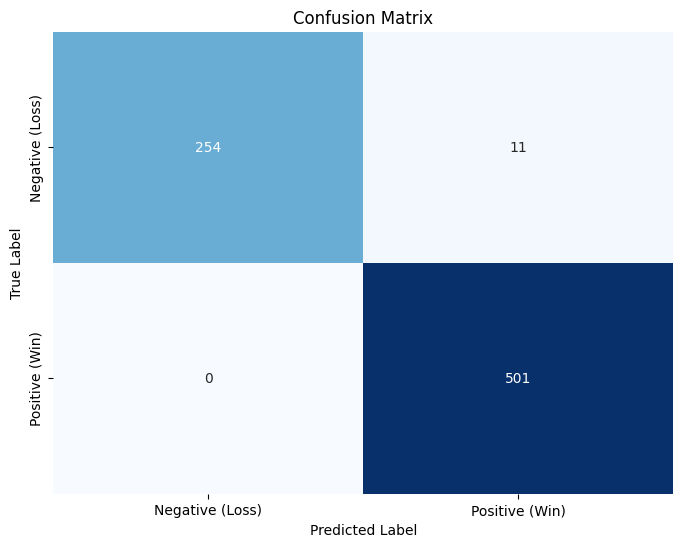

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        67
           1       0.96      1.00      0.98       125

    accuracy                           0.97       192
   macro avg       0.98      0.96      0.97       192
weighted avg       0.97      0.97      0.97       192



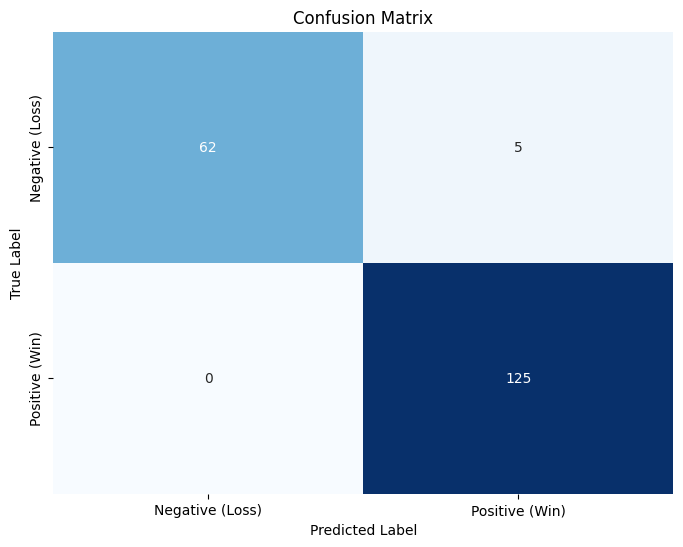

In [9]:
def plot_confusion_matrix(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Create Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Text Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative (Loss)', 'Positive (Win)'],
                yticklabels=['Negative (Loss)', 'Positive (Win)'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(log_model, X_train, y_train)
plot_confusion_matrix(log_model, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.43      0.50       265
           1       0.74      0.85      0.79       501

    accuracy                           0.70       766
   macro avg       0.67      0.64      0.64       766
weighted avg       0.69      0.70      0.69       766



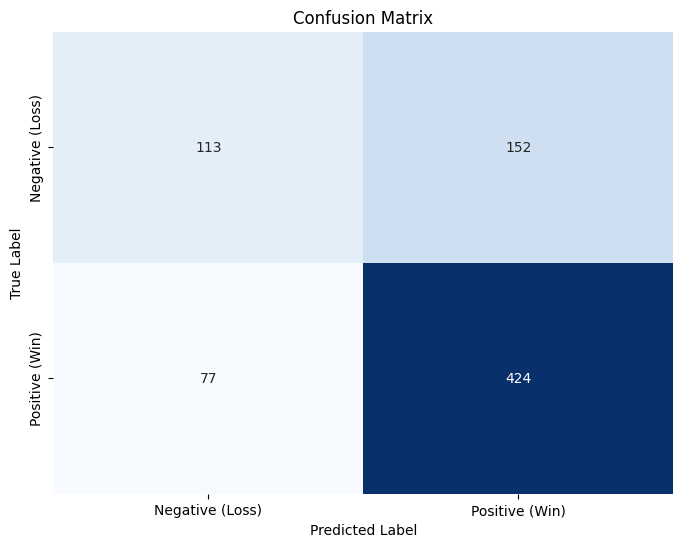

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.33      0.42        67
           1       0.71      0.87      0.78       125

    accuracy                           0.68       192
   macro avg       0.64      0.60      0.60       192
weighted avg       0.66      0.68      0.65       192



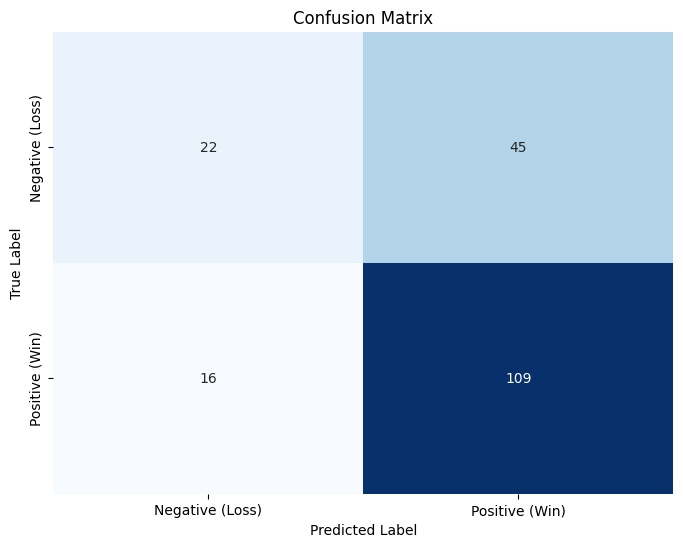

In [10]:
plot_confusion_matrix(nb_model, X_train, y_train)
plot_confusion_matrix(nb_model, X_test, y_test)

## Calculation of Probability of Error


Calculate the **Probability of Error** for both the training and testing datasets manually.

**The Method:**
1. We compare the predicted outcome $\hat{y}_{m,1}$ with the real outcome $y_{m,1}$.
2. If they differ, we set $error_i = 1$.
3. If they are the same, we set $error_i = 0$.
4. We count the number of errors for the $N$ dataset.

**The Formula:**
$$ \text{probability of error} = \frac{1}{N} \sum_{i=1}^{N} error_i $$

### **Logistics regression**


In [11]:
def calculate_custom_prob_error(model, X, y_true, dataset_name="Data"):
    """
    Calculates probability of error based on the formula:
    Prob_Error = (1/N) * Sum(error_i)
    where error_i = 1 if prediction != actual else 0
    """
    # 1. Get Predictions
    y_pred = model.predict(X)

    # 2. Calculate N (Total number of samples)
    N = len(y_true)

    # 3. Calculate error_i for each sample
    # (y_true != y_pred) creates a boolean array (True if error, False if correct)
    # .astype(int) converts True to 1 and False to 0
    error_i_list = (y_true != y_pred).astype(int)

    # 4. Sum the errors
    total_errors = error_i_list.sum()

    # 5. Calculate Probability
    prob_error = (1 / N) * total_errors

    print(f"--- {dataset_name} Set Evaluation ---")
    print(f"Total Samples (N): {N}")
    print(f"Total Errors (Sum of error_i): {total_errors}")
    print(f"Probability of Error: {prob_error:.4f} (or {prob_error*100:.2f}%)")
    print("-" * 40)
    print("\n")

    return prob_error

# Calculate for Training Data
prob_error_train = calculate_custom_prob_error(log_model, X_train, y_train, "Training")

# Calculate for Testing Data
prob_error_test = calculate_custom_prob_error(log_model, X_test, y_test, "Testing")

--- Training Set Evaluation ---
Total Samples (N): 766
Total Errors (Sum of error_i): 11
Probability of Error: 0.0144 (or 1.44%)
----------------------------------------


--- Testing Set Evaluation ---
Total Samples (N): 192
Total Errors (Sum of error_i): 5
Probability of Error: 0.0260 (or 2.60%)
----------------------------------------




### **Naive Bayes**


In [12]:
# Calculate for Training Data
prob_error_train = calculate_custom_prob_error(nb_model, X_train, y_train, "Training")

# Calculate for Testing Data
prob_error_test = calculate_custom_prob_error(nb_model, X_test, y_test, "Testing")

--- Training Set Evaluation ---
Total Samples (N): 766
Total Errors (Sum of error_i): 229
Probability of Error: 0.2990 (or 29.90%)
----------------------------------------


--- Testing Set Evaluation ---
Total Samples (N): 192
Total Errors (Sum of error_i): 61
Probability of Error: 0.3177 (or 31.77%)
----------------------------------------




## Conclusion

### **A. Logistic Regression (Best Performer)**
Performance: This model achieved near-perfect performance with a 97.4% test accuracy.

Confusion Matrix Analysis:

True Positives (Win): 125

True Negatives (Loss): 62

False Negatives: 0 (The model never missed a Win).

False Positives: 5 (The model incorrectly predicted a Win for 5 Loss states).

Insight: The linear decision boundary of Logistic Regression proved highly effective for this dataset. The 0 False Negative rate is particularly impressive, making this model ideal if the priority is ensuring no winning opportunities are overlooked.​

### **B. Gaussian Naive Bayes**
Performance: The Naive Bayes model underperformed significantly, with a 68.23% test accuracy.​

Confusion Matrix Analysis:

It struggled heavily with False Positives (45 errors), frequently classifying Loss states as Wins.

It also had a notable number of False Negatives (16), missing actual Wins.

Why it failed: Naive Bayes assumes that features (board cells) are independent of each other. In Tic-Tac-Toe, board positions are highly correlated (e.g., an 'X' in the center directly blocks specific winning lines for 'O'). The violation of this independence assumption likely caused the poor performance.


### **Therefore,**
Logistic Regression is the superior model for this task.

The gap in accuracy (~29%) demonstrates that the relationships between board states in Tic-Tac-Toe are better captured by the discriminative nature of Logistic Regression rather than the probabilistic independence assumed by Gaussian Naive Bayes.